# Workshop 6  - Desarrollo
## Parte 1 - Carga y tratamiento de datos geográficos y estadísticos disponibles
1. Carga de todos los insumos cartográficos disponibles y reproyección a EPSG 9377
2. Carga de los datos de EVAS desde csv
3. Carga de los datos de estaciones IDEAM desde el csv
4. Conversión a información cartográfica de las coordenadas de ubicación del csv de estaciones
5. Establecer sistema coordenado EPSG 4326 para estaciones y reproyectar a EPSG 9377
6. Selección de municipios a partir de su rendimiento para el cultivo de **Palma de Aceite**

In [31]:
#1 Carga de librerías
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as cx
from pathlib import Path
import pandas as pd
from shapely.geometry import Point
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

In [84]:
# Carga de archivos csv y shp
archivos_CSV=r"/notebooks/Datos_Geograficos"
SHP=r"/notebooks/Datos_Geograficos/"

shp_ruta=SHP+r"municipios_colombia/municipios_colombia.shp"
muni_shp = gpd.read_file(shp_ruta)
muni_shp = muni_shp.to_crs(9377)

evas_ruta  = archivos_CSV+"/Evaluaciones_Agropecuarias_Municipales_EVA.csv"
evas = pd.read_csv(evas_ruta, encoding='utf-8')

estaciones_csv=archivos_CSV+"/Catalogo_Estaciones_IDEAM.csv"
estaciones = pd.read_csv(estaciones_csv, encoding='utf-8')

print("\nSISTEMA COORDENADO DEL SHP:\n", muni_shp.crs)
print('\n COLUMNAS DE ESTACIONES\n',estaciones.columns.tolist())



SISTEMA COORDENADO DEL SHP:
 EPSG:9377

 COLUMNAS DE ESTACIONES
 ['Codigo', 'Nombre', 'Categoria', 'Estado', 'Departamento', 'Municipio', 'Ubicación', 'Altitud', 'Fecha_instalacion', 'Fecha_suspension', 'Corriente']


In [14]:
# Renombra columnas y lectura de códigos de departamento y municipio - Shape 
muni_shp = muni_shp.rename(columns = {"DPTO_CCDGO":"DPTO_COD","MPIO_CDPMP":"MUN_COD","DPTO_CCDGO":"DPTO_COD","MPIO_CNMBR":"MPIO_NOM"}) # se renombran columnas
muni_shp['MUN_COD'] = muni_shp['MUN_COD'].astype(str).str.zfill(5) # leer columna de codigo municipal como texto y mantener los 5 caracteres siempre
muni_shp['DPTO_COD'] = muni_shp['DPTO_COD'].astype(str).str.zfill(5) # leer columna de codigo departamental como texto y mantener los 5 caracteres siempre
print('\nCOLUMNAS DEL SHAPE RENOMBRADAS\n',muni_shp.columns.tolist())

# Renombra columnas y lectura de códigos de departamento y municipio - csv EVAS 
evas = evas.rename(columns = {"CÓD. \nDEP.":"DPTO_COD","CÓD. MUN.":"MUN_COD","GRUPO \nDE CULTIVO":"GRUPO DE CULTIVO","SUBGRUPO \nDE CULTIVO":"SUBGRUPO_DE_CULTIVO",\
                       "Área Sembrada\n(ha)":"Área Sembrada_(ha)","Área Cosechada\n(ha)":"Área Cosechada_(ha)","Producción\n(t)":"Producción_(t)",\
                      "Rendimiento\n(t/ha)":"Rendimiento_(t/ha)","NOMBRE \nCIENTIFICO":"NOMBRE_CIENTIFICO"})
evas['MUN_COD'] = evas ['MUN_COD'].astype(str).str.zfill(5)
evas['DPTO_COD'] = evas ['DPTO_COD'].astype(str).str.zfill(5)
evas["CULTIVO"] = evas["CULTIVO"].astype(str) 
print('\nCOLUMNAS DE EVAS RENOMBRADAS\n',evas.columns.tolist(),'\n')

print('\nCantidad de valores por codigo municipal: \n', muni_shp['MUN_COD'].value_counts())


COLUMNAS DEL SHAPE RENOMBRADAS
 ['DPTO_COD', 'MPIO_CCDGO', 'MPIO_NOM', 'MUN_COD', 'VERSION', 'AREA', 'LATITUD', 'LONGITUD', 'STCTNENCUE', 'STP3_1_SI', 'STP3_2_NO', 'STP3A_RI', 'STP3B_TCN', 'STP4_1_SI', 'STP4_2_NO', 'STP9_1_USO', 'STP9_2_USO', 'STP9_3_USO', 'STP9_4_USO', 'STP9_2_1_M', 'STP9_2_2_M', 'STP9_2_3_M', 'STP9_2_4_M', 'STP9_2_9_M', 'STP9_3_1_N', 'STP9_3_2_N', 'STP9_3_3_N', 'STP9_3_4_N', 'STP9_3_5_N', 'STP9_3_6_N', 'STP9_3_7_N', 'STP9_3_8_N', 'STP9_3_9_N', 'STP9_3_10', 'STP9_3_99', 'STVIVIENDA', 'STP14_1_TI', 'STP14_2_TI', 'STP14_3_TI', 'STP14_4_TI', 'STP14_5_TI', 'STP14_6_TI', 'STP15_1_OC', 'STP15_2_OC', 'STP15_3_OC', 'STP15_4_OC', 'TSP16_HOG', 'STP19_EC_1', 'STP19_ES_2', 'STP19_EE_1', 'STP19_EE_2', 'STP19_EE_3', 'STP19_EE_4', 'STP19_EE_5', 'STP19_EE_6', 'STP19_EE_9', 'STP19_ACU1', 'STP19_ACU2', 'STP19_ALC1', 'STP19_ALC2', 'STP19_GAS1', 'STP19_GAS2', 'STP19_GAS9', 'STP19_REC1', 'STP19_REC2', 'STP19_INT1', 'STP19_INT2', 'STP19_INT9', 'STP27_PERS', 'STPERSON_L', 'STPERSON_S', 'ST

In [15]:
# Obtener las coordenadas de las estaciones y convertir a geometría de punto
estaciones[['lat','lon']] = estaciones['Ubicación'].str.strip("()").str.split(",",expand=True)
estaciones['lat'] = estaciones['lat'].astype(float)
estaciones['lon'] = estaciones['lon'].astype(float)
estaciones["geometry"] = estaciones.apply(lambda row: Point(row["lon"], row["lat"]), axis=1)
estaciones = gpd.GeoDataFrame(estaciones, geometry="geometry")
estaciones = estaciones.set_crs('epsg:4326')

# Reproyección de geodataframe de estaciones
estaciones = estaciones.to_crs(epsg=9377)
print("\nSISTEMA COORDENADO DE ESTACIONES:\n", estaciones.crs)
#print('\n\nCultivos del país:\n\n',sorted(evas["CULTIVO"].unique()))


SISTEMA COORDENADO DE ESTACIONES:
 EPSG:9377


In [17]:
# Merge de los datos de evas y el mapa de municipios del país
mun_cultivos = muni_shp.merge(
    evas,
    how='left',
    left_on='MUN_COD',
    right_on='MUN_COD',
    validate='one_to_many',
    suffixes=('', '_evas')
)

print(mun_cultivos.head())

  DPTO_COD MPIO_CCDGO   MPIO_NOM MUN_COD  VERSION          AREA   LATITUD  \
0    00018        001  FLORENCIA   18001     2018  2.547638e+09  1.749139   
1    00018        001  FLORENCIA   18001     2018  2.547638e+09  1.749139   
2    00018        001  FLORENCIA   18001     2018  2.547638e+09  1.749139   
3    00018        001  FLORENCIA   18001     2018  2.547638e+09  1.749139   
4    00018        001  FLORENCIA   18001     2018  2.547638e+09  1.749139   

    LONGITUD  STCTNENCUE  STP3_1_SI  ...  \
0 -75.558239     71877.0       32.0  ...   
1 -75.558239     71877.0       32.0  ...   
2 -75.558239     71877.0       32.0  ...   
3 -75.558239     71877.0       32.0  ...   
4 -75.558239     71877.0       32.0  ...   

   DESAGREGACIÓN REGIONAL Y/O SISTEMA PRODUCTIVO     AÑO  PERIODO  \
0                                        AHUYAMA  2010.0    2010B   
1                                        AHUYAMA  2011.0    2011A   
2                                        AHUYAMA  2012.0    2012A

       DPTO_COD MPIO_CCDGO                MPIO_NOM MUN_COD  VERSION  \
446       00018        094  BELÉN DE LOS ANDAQUÍES   18094     2018   
10146     00019        318                   GUAPI   19318     2018   
40363     00052        427                   MAGÜÍ   52427     2018   
41621     00099        624           SANTA ROSALÍA   99624     2018   
41909     00099        524            LA PRIMAVERA   99524     2018   
...         ...        ...                     ...     ...      ...   
185901    00068        689  SAN VICENTE DE CHUCURÍ   68689     2018   
186362    00068        745                SIMACOTA   68745     2018   
191349    00068        573            PUERTO PARRA   68573     2018   
191468    00068        575          PUERTO WILCHES   68575     2018   
198950    00073        275                 FLANDES   73275     2018   

                AREA   LATITUD   LONGITUD  STCTNENCUE  STP3_1_SI  ...  \
446     1.191619e+09  1.500923 -75.875645      4243.0       54.0  ...   
1

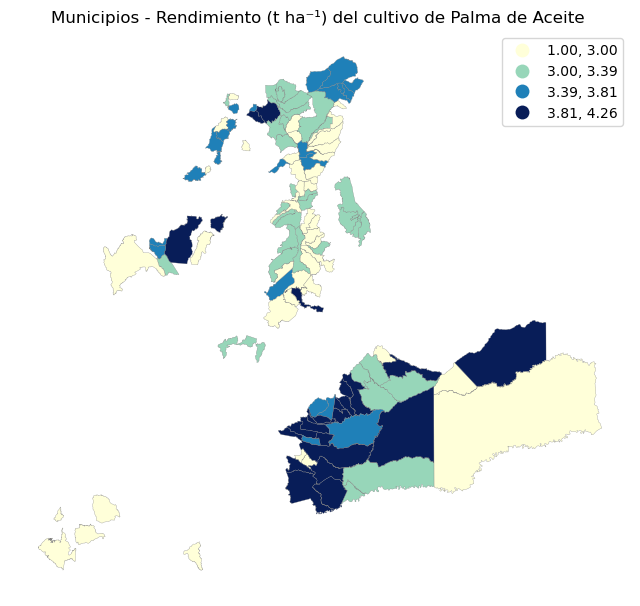

In [54]:
# Subset para municipios que reporten cultivo de palma de aceite para el año 2018
año = 2018
cultivo = 'PALMA DE ACEITE'
palma_mun_18 = (
    mun_cultivos.query("CULTIVO == @cultivo and AÑO == @año").copy()
)

print(palma_mun_18)
ax1 = palma_mun_18.plot(column='Rendimiento_(t/ha)',scheme ='Quantiles',k=4,cmap='YlGnBu',legend=True,figsize=(8,8),edgecolor='grey',linewidth=0.2)
ax1.set_title('Municipios - Rendimiento (t ha⁻¹) del cultivo de Palma de Aceite ')
ax1.set_axis_off()
plt.show()

## Parte 2 - Selección municipal
1. Seleccionar municipios que estén dentro del 3 y 4 cuartil de rendimiento (t/ha), es decir que tengan rendimientos ≥ 3.39 [t/ha] 
2. Determinar la cantidad de estaciones del IDEAM dentro de los municpios y fuera con un alcance máximo de 6km
3. Cuantificar densidad para drenajes dobles y sencillos por municipio
4. Determinar densidad de vías por municipio (km de vía/area municipal)
5. Selección de municipio con la mayor cantidad de cuerpos de agua de tipo drenaje sencillo o doble y la mayor densidad de vías para transportar insumos y carga

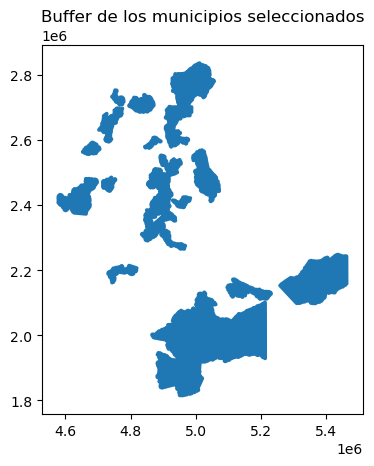

Columnas de estaciones_palma 
 ['Codigo', 'Nombre', 'Categoria', 'Estado', 'Departamento', 'Municipio', 'Ubicación', 'Altitud', 'Fecha_instalacion', 'Fecha_suspension', 'Corriente', 'lat', 'lon', 'geometry', 'index_right', 'DPTO_COD', 'MPIO_CCDGO', 'MPIO_NOM', 'MUN_COD', 'VERSION', 'AREA', 'LATITUD', 'LONGITUD', 'STCTNENCUE', 'STP3_1_SI', 'STP3_2_NO', 'STP3A_RI', 'STP3B_TCN', 'STP4_1_SI', 'STP4_2_NO', 'STP9_1_USO', 'STP9_2_USO', 'STP9_3_USO', 'STP9_4_USO', 'STP9_2_1_M', 'STP9_2_2_M', 'STP9_2_3_M', 'STP9_2_4_M', 'STP9_2_9_M', 'STP9_3_1_N', 'STP9_3_2_N', 'STP9_3_3_N', 'STP9_3_4_N', 'STP9_3_5_N', 'STP9_3_6_N', 'STP9_3_7_N', 'STP9_3_8_N', 'STP9_3_9_N', 'STP9_3_10', 'STP9_3_99', 'STVIVIENDA', 'STP14_1_TI', 'STP14_2_TI', 'STP14_3_TI', 'STP14_4_TI', 'STP14_5_TI', 'STP14_6_TI', 'STP15_1_OC', 'STP15_2_OC', 'STP15_3_OC', 'STP15_4_OC', 'TSP16_HOG', 'STP19_EC_1', 'STP19_ES_2', 'STP19_EE_1', 'STP19_EE_2', 'STP19_EE_3', 'STP19_EE_4', 'STP19_EE_5', 'STP19_EE_6', 'STP19_EE_9', 'STP19_ACU1', 'STP19_ACU

In [68]:
#Seleccionar municipios que tengan rendimiento mayor a 3.39 [t/ha]

rend_inf = 3.39
palma_mun_r = palma_mun_18[palma_mun_18['Rendimiento_(t/ha)']>=rend_inf]
# Crear copia de selección y neva columna de buffer estableciéndola como la columna de geometría principal
palma_buff = palma_mun_r.copy()
palma_buff["geometry_20km"] = palma_buff.geometry.buffer(6000)
palma_buff =palma_buff .set_geometry("geometry_20km")
# Grafica de solo buffer para ver que funcione
ax1 = palma_buff.plot()
ax1.set_title('Buffer de los municipios seleccionados')
plt.show()

# Spatial Join para determinar las estaciones dentro de los municipios y hasta 6km fuera de ellos (buffer)
estaciones_palma = gpd.sjoin(
    estaciones,                 # left: station points
    palma_buff,     # right: buffer polygons
    how='inner',            # keep only points that intersect the buffer
    predicate='within'  # or 'within'
)
print('Columnas de estaciones_palma \n',estaciones_palma.columns.tolist())

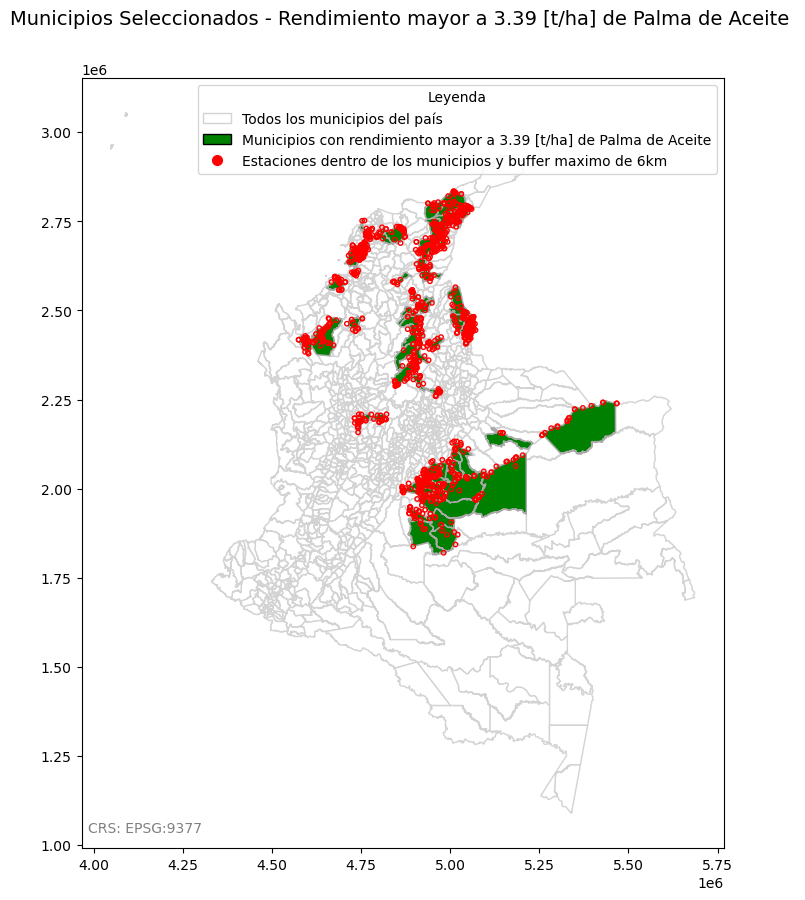

In [59]:
# Crear la gráfica de los municipios seleccionados con las estaciones.
fig, ax = plt.subplots(figsize=(10, 10))

# 1. Capa base - todos los municipios
muni_shp.plot(
    ax=ax,
    color='white',
    edgecolor='lightgrey'
)
# 2. Resalta municipios de rendimiento mayor a 3.39
palma_mun_r.plot(
    ax=ax,
    color='green',
    edgecolor='darkgrey'
)

# 3. Plot stations not in Cumaribo
estaciones_palma.plot(
    ax=ax,
    color='None',
    edgecolor='red',
    marker='o',
    markersize=10
)

# 4. Titulo del gráfico
ax.set_title(
    "Municipios Seleccionados - Rendimiento mayor a 3.39 [t/ha] de Palma de Aceite \n",
    fontsize=14,
    pad=12
)

# 5. Crea los elementos gráficos para la leyenda
#    - Todos los municipios en blanco con línea gris
patch_allmun = mpatches.Patch(
    facecolor='white',
    edgecolor='lightgrey',
    label='Todos los municipios del país'
)

#    - Municipios seleccionados con relleno verde y línea negra
patch_palma_mun_r = mpatches.Patch(
    facecolor='green',
    edgecolor='black',
    label='Municipios con rendimiento mayor a 3.39 [t/ha] de Palma de Aceite'
)

#    - Linea para las estaciones seleccionadas
marker_stations = mlines.Line2D(
    [], [], 
    color='red',   # edgecolor of the marker
    marker='o',
    linestyle='None',
    markersize=7,
    label='Estaciones dentro de los municipios y buffer maximo de 6km'
)

# 6. Crea la leyenda con las especificaciones gráficas ya hechas
ax.legend(
    handles=[patch_allmun, patch_palma_mun_r,marker_stations],
    loc='upper right',
    title='Leyenda',
    frameon=True
)

# 7. Crea la anotación del CRS en la parte inferior izquierda
crs_text = f"CRS: {muni_shp.crs.to_string()}"
ax.text(
    0.01, 0.02, crs_text,
    transform=ax.transAxes,
    fontsize=10,
    color='grey',
    bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, pad=2)
)

plt.show()

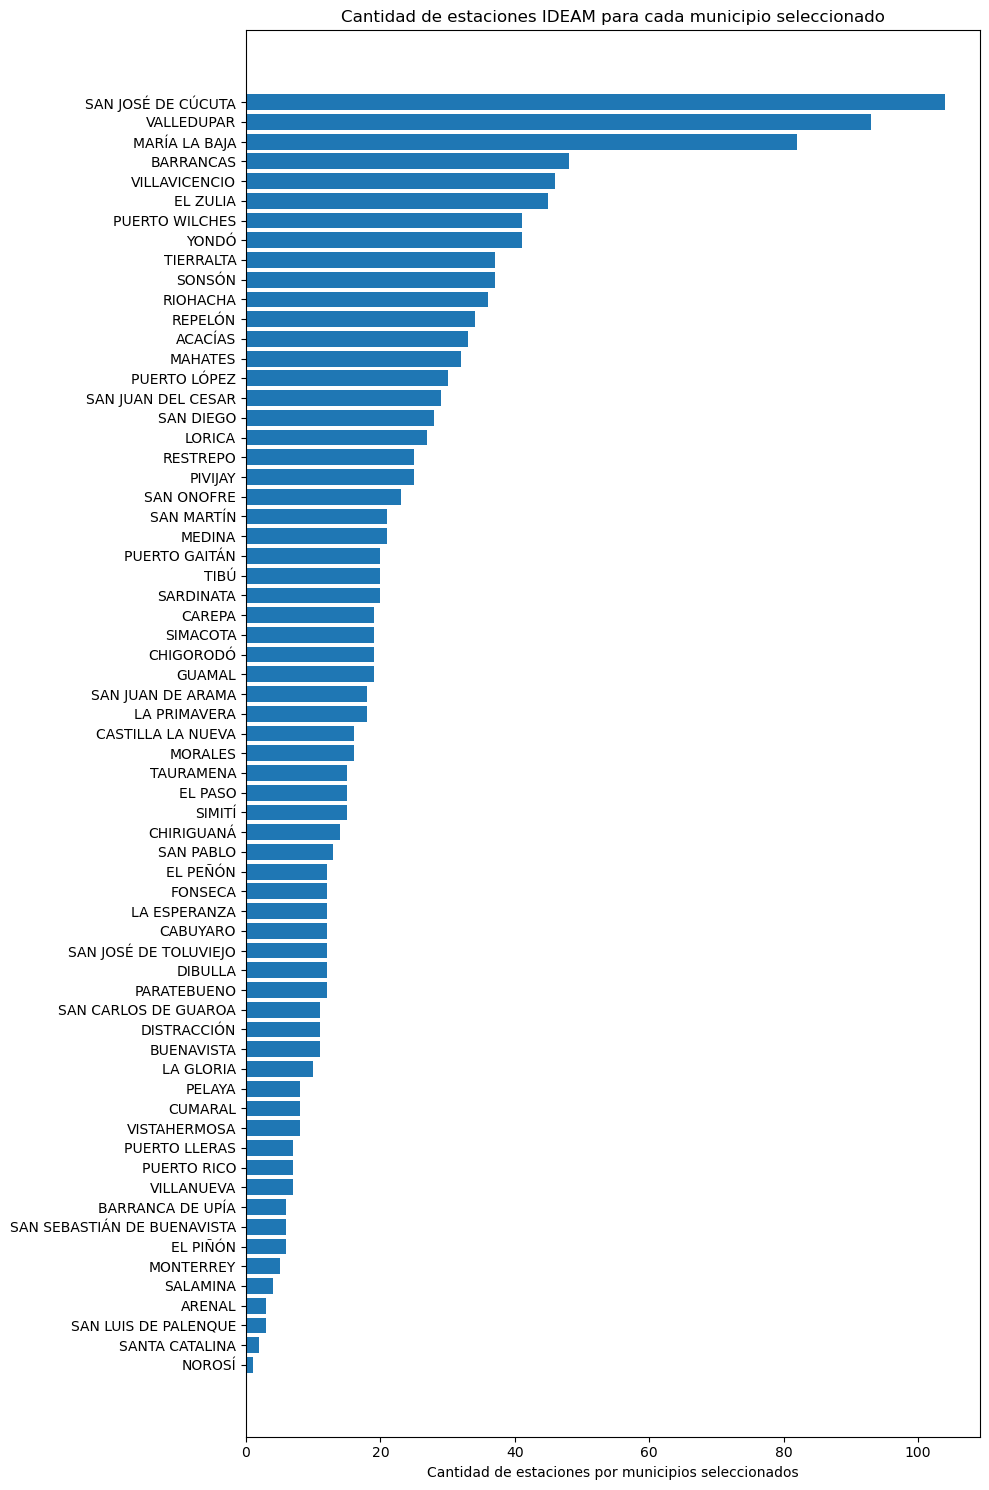

Columnas limpias
 ['DEPARTAMENTO', 'DPTO_COD', 'MPIO_NOM', 'MUN_COD', 'Area_Ha', 'CULTIVO', 'Área Sembrada_(ha)', 'Área Cosechada_(ha)', 'Producción_(t)', 'Rendimiento_(t/ha)', 'n_estaciones', 'geometry', 'AREA_HA']


/opt/miniconda/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [140]:
# Conteo de estaciones dentro de cada municipio
conteo_estaciones = estaciones_palma.groupby('MUN_COD').size().reset_index(name='n_estaciones')
# Merge de los datos de municipios seleccionados por redimieno y el conteo de estaciones
palma_mun_r_e = palma_mun_r.merge(
    conteo_estaciones,
    how='left',
    left_on='MUN_COD',
    right_on='MUN_COD',
    validate='one_to_one'
)

#Organizar el gdf por el conteo de estaciones de forma ascendente
palma_mun_r_e_barras = palma_mun_r_e.sort_values('n_estaciones',ascending=True)

# Gráfico de barras horizontal con el conteo de estaciones
fig, ax = plt.subplots(figsize=(10, 15))
ax.barh(palma_mun_r_e_barras['MPIO_NOM'], palma_mun_r_e_barras['n_estaciones'])
ax.set_xlabel('Cantidad de estaciones por municipios seleccionados')
ax.set_title(f'Cantidad de estaciones IDEAM para cada municipio seleccionado')
plt.tight_layout()
plt.show()

# Limpieza del gdf

palma_mun_l = palma_mun_r_e[['DEPARTAMENTO','DPTO_COD','MPIO_NOM', 'MUN_COD','Area_Ha','CULTIVO','Área Sembrada_(ha)', \
                                           'Área Cosechada_(ha)', 'Producción_(t)', 'Rendimiento_(t/ha)','n_estaciones','geometry']]
print('Columnas limpias\n',palma_mun_l.columns.tolist())

In [91]:
# Ruta para cargar nuevos archivos shp
SHP=r"/notebooks/Datos_Geograficos/"

vias_ruta=SHP+r"Vias/Vias_Colombia.shp"
dr_sencillo_ruta=SHP+r"Cuerpos_Agua/Drenaje_Sencillo.shp"
dr_doble_ruta=SHP+r"Cuerpos_Agua/Drenaje_Doble.shp"

print(vias_ruta)
print(dr_sencillo_ruta)
print(dr_doble_ruta)


/notebooks/Datos_Geograficos/Vias/Vias_Colombia.shp
/notebooks/Datos_Geograficos/Cuerpos_Agua/Drenaje_Sencillo.shp
/notebooks/Datos_Geograficos/Cuerpos_Agua/Drenaje_Doble.shp


In [108]:
# Carga de archivos shp y reproyección EPSG 9377
vias_shp = gpd.read_file(vias_ruta)
vias_shp = vias_shp.to_crs(9377)

dren_s_shp = gpd.read_file(dr_sencillo_ruta)
dren_s_shp = dren_s_shp.to_crs(9377)

dren_d_shp = gpd.read_file(dr_doble_ruta)
dren_d_shp = dren_d_shp.to_crs(9377)

/opt/miniconda/lib/python3.11/site-packages/pyogrio/raw.py:196: RuntimeWarning: organizePolygons() received an unexpected geometry.  Either a polygon with interior rings, or a polygon with less than 4 points, or a non-Polygon geometry.  Return arguments as a collection.
  return ogr_read(
/opt/miniconda/lib/python3.11/site-packages/pyogrio/raw.py:196: RuntimeWarning: Geometry of polygon of fid 1638 cannot be translated to Simple Geometry. All polygons will be contained in a multipolygon.
  return ogr_read(


In [119]:
#Selecciona solo las vias hasta tercer nivel
vias_shp_t1 = vias_shp[vias_shp['TIPO_VIA']<=3]
# print(vias_shp_t1.head(10))

# print(dren_s_shp.head(10))

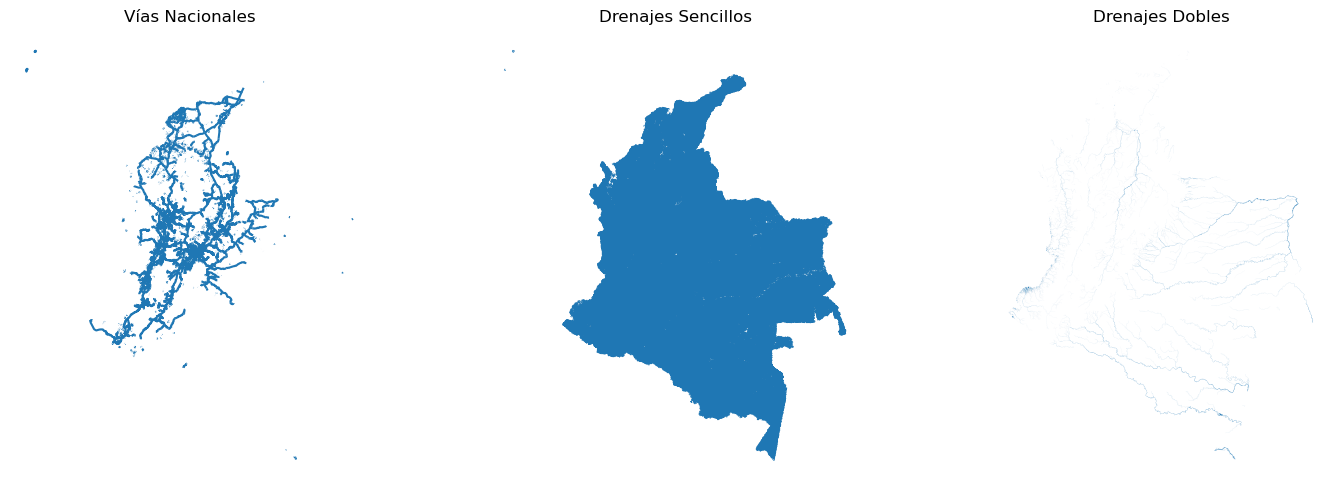

In [113]:
# Pruebas de gráficas para revisión del cargue de capas cartográficas
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plotear cada capa en su respectivo subplot
vias_shp_t1.plot(ax=ax1)
ax1.set_title('Vías Nacionales')
ax1.set_axis_off()

dren_s_shp.plot(ax=ax2)
ax2.set_title('Drenajes Sencillos')
ax2.set_axis_off()

dren_d_shp.plot(ax=ax3)
ax3.set_title('Drenajes Dobles')
ax3.set_axis_off()

plt.tight_layout()
plt.show()

In [141]:
# Clip de municipios seleccionados contra vias y drenajes
# print(type(palma_mun_l))

vias_clip = gpd.clip(vias_shp_t1,palma_mun_l)
dren_d_clip = gpd.clip(dren_d_shp,palma_mun_l)
print('Terminé los clips')

Terminé los clips


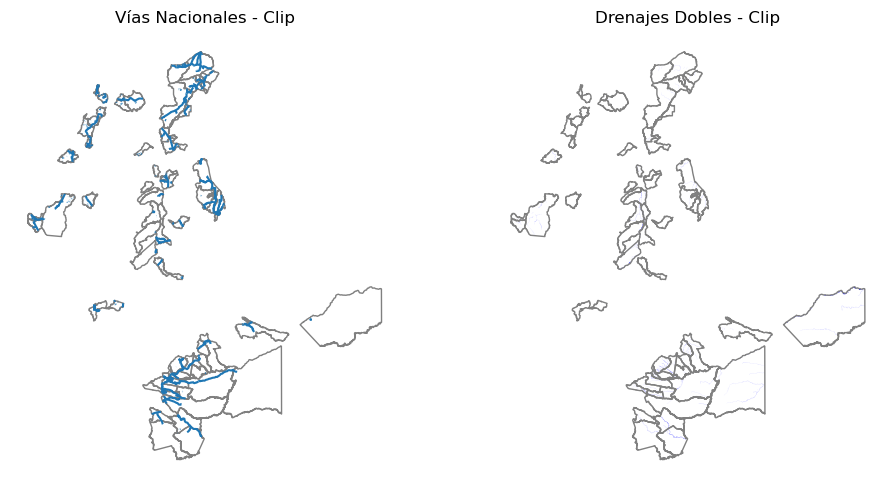

In [158]:
# Crea figura para los subplots
fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(10, 5))

# Plotear cada capa en su respectivo subplot
vias_clip.plot(ax=ax1)
palma_mun_l.plot(ax=ax1,color="none", edgecolor="grey")
ax1.set_title('Vías Nacionales - Clip')
ax1.set_axis_off()
dren_d_clip.plot(ax=ax3, color="blue")
palma_mun_l.plot(ax=ax3,color="none", edgecolor="grey")
ax3.set_title('Drenajes Dobles - Clip')
ax3.set_axis_off()

plt.tight_layout()
plt.show()

In [164]:
#Calculo de longitud de vias en km

vias_clip['longitud_vias'] = vias_clip.length/1e3
# print('VIAS \n',vias_clip.head(2))

#Calculo de longitud de drenajes dobles en km
dren_d_clip['longitud_drenajes_d'] = dren_d_clip.length/1e3
# print('Drenajes \n',dren_d_clip.head(2))

# Limpieza de columnas para vias y drenajes

vias_clip = vias_clip[['TIPO_VIA','longitud_vias','geometry']]
dren_d_clip = dren_d_clip[['OBJECTID','longitud_drenajes_d','geometry']]

#Spatial Join para obtener los codigos municipales de vías y drenajes
vias_j = gpd.sjoin(
    vias_clip,                 # left: station points
    palma_mun_l,     # right: buffer polygons
    how='inner',            # keep only points that intersect the buffer
    predicate='within'  # or 'within'
)
dren_d_j = gpd.sjoin(
    dren_d_clip,                 # left: station points
    palma_mun_l,     # right: buffer polygons
    how='inner',            # keep only points that intersect the buffer
    predicate='within'  # or 'within'
)

vias_j_l = vias_j.groupby('MUN_COD')[['longitud_vias']].sum().reset_index()
dren_d_j_l = dren_d_j.groupby('MUN_COD')[['longitud_drenajes_d']].sum().reset_index()

print(vias_j_l.head(5))
print(dren_d_j_l.head(5))

# Limpieza 2 de columnas para vias y drenajes

# vias_j = vias_j[['TIPO_VIA','longitud_vias','MUN_COD']]
# dren_d_j = dren_d_j[['OBJECTID','longitud_drenajes_d','MUN_COD']]

# print('\nVias\n',vias_j.head(1))
# print('\nDrenajes\n',dren_d_j.head(1))


  MUN_COD  longitud_vias
0   05147      33.240327
1   05172      11.462453
2   05756      53.153357
3   05893      21.481308
4   08606      13.564231
  MUN_COD  longitud_drenajes_d
0   05147            95.742624
1   05172            98.178842
2   05893           148.170870
3   13268            29.205893
4   13744            77.753263


In [176]:
# Merge contra shape de municipios selecionados para adicionar los datos calculados de vias y drenajes
palma_mun_l_v = palma_mun_l.merge(
    vias_j_l,
    how='left',                 # unir evas a municipios
    left_on='MUN_COD',          # columna clave en municipios
    right_on='MUN_COD',         # columna clave en vias
    validate='one_to_many',     # relación uno-muchos para que se unan todos los registros de cultivos por municipio
    suffixes=('', '_vias')    
)
palma_mun_T = palma_mun_l_v.merge(
    dren_d_j_l,
    how='left',                 # unir evas a municipios
    left_on='MUN_COD',          # columna clave en municipios
    right_on='MUN_COD',         # columna clave en vias
    validate='one_to_one',     # relación uno-muchos para que se unan todos los registros de cultivos por municipio
    suffixes=('', '_dren')    
)

palma_mun_T['AREA_HA'] = palma_mun_T.area/1e4

palma_mun_T['Dens_Vias'] = palma_mun_T['longitud_vias']/palma_mun_T['AREA_HA']
palma_mun_T['Dens_Dren_d'] = palma_mun_T['longitud_drenajes_d']/palma_mun_T['AREA_HA']
print(palma_mun_T.columns.tolist())

# Funcion de calificación para tener en cuenta los parámetros de estaciones, vías y drenajes
palma_mun_T['Calificacion'] = (palma_mun_T['n_estaciones']*0.33)+(palma_mun_T['Dens_Vias']*0.33)+(palma_mun_T['Dens_Dren_d']*0.33)

#Organizar el gdf por la calificación
palma_mun_T = palma_mun_T.sort_values('Calificacion',ascending=False)
print('MUNICIPIO SELECCIONADO CON CALIFICACIÓN MÁS ALTA\n',palma_mun_T.iloc[0])

mun_sel =palma_mun_T.iloc[0]

['DEPARTAMENTO', 'DPTO_COD', 'MPIO_NOM', 'MUN_COD', 'Area_Ha', 'CULTIVO', 'Área Sembrada_(ha)', 'Área Cosechada_(ha)', 'Producción_(t)', 'Rendimiento_(t/ha)', 'n_estaciones', 'geometry', 'AREA_HA', 'longitud_vias', 'longitud_drenajes_d', 'Dens_Vias', 'Dens_Dren_d']
MUNICIPIO SELECCIONADO CON CALIFICACIÓN MÁS ALTA
 DEPARTAMENTO                                                       CESAR
DPTO_COD                                                           00020
MPIO_NOM                                                      VALLEDUPAR
MUN_COD                                                            20001
Area_Ha                                                       418528.699
CULTIVO                                                  PALMA DE ACEITE
Área Sembrada_(ha)                                                3200.0
Área Cosechada_(ha)                                               3200.0
Producción_(t)                                                   10848.0
Rendimiento_(t/ha)         

In [ ]:
# Crear la gráfica de los municipios seleccionados con las estaciones.
fig, ax = plt.subplots(figsize=(10, 10))

# 1. Capa base - todos los municipios
muni_shp.plot(
    ax=ax,
    color='white',
    edgecolor='lightgrey'
)
# 2. Resalta municipios de rendimiento mayor a 3.39
mun_sel.plot(
    ax=ax,
    color='green',
    edgecolor='darkgrey'
)

# 3. Plot stations not in Cumaribo
estaciones_palma.plot(
    ax=ax,
    color='None',
    edgecolor='red',
    marker='o',
    markersize=10
)

# 4. Titulo del gráfico
ax.set_title(
    "Municipios Seleccionados - Rendimiento mayor a 3.39 [t/ha] de Palma de Aceite \n",
    fontsize=14,
    pad=12
)

# 5. Crea los elementos gráficos para la leyenda
#    - Todos los municipios en blanco con línea gris
patch_allmun = mpatches.Patch(
    facecolor='white',
    edgecolor='lightgrey',
    label='Todos los municipios del país'
)

#    - Municipios seleccionados con relleno verde y línea negra
patch_palma_mun_r = mpatches.Patch(
    facecolor='green',
    edgecolor='black',
    label='Municipios con rendimiento mayor a 3.39 [t/ha] de Palma de Aceite'
)

#    - Linea para las estaciones seleccionadas
marker_stations = mlines.Line2D(
    [], [], 
    color='red',   # edgecolor of the marker
    marker='o',
    linestyle='None',
    markersize=7,
    label='Estaciones dentro de los municipios y buffer maximo de 6km'
)

# 6. Crea la leyenda con las especificaciones gráficas ya hechas
ax.legend(
    handles=[patch_allmun, patch_palma_mun_r,marker_stations],
    loc='upper right',
    title='Leyenda',
    frameon=True
)

# 7. Crea la anotación del CRS en la parte inferior izquierda
crs_text = f"CRS: {muni_shp.crs.to_string()}"
ax.text(
    0.01, 0.02, crs_text,
    transform=ax.transAxes,
    fontsize=10,
    color='grey',
    bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, pad=2)
)

plt.show()

## Parte 3 - Identificar mejor zona para establecer cultivo
1. Identificar las áreas aptas que están dentro de la Frontera Agrícola
2. Subdivisión por grilla de 1ha
3. Excluir zonas con distancias ≤ 50m a drenajes dobles o sencillos y excluir zonas que contengan otros cuerpos de agua
5. Distancia a las vías de acceso (≤ 1km)

In [ ]:
# Codigo